In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 21 Sep 2018 21:55

@author: Adil
"""

# Australian Airline Dataset


This dataset describes flight route data in Australia for 7 airlines. There are 136 routes that fly betwen 41 ports. Data was sampled every month for the four year range beginning January 2015 and ending May 2018.

This notebook is an exploratory analysis of this dataset. Bokeh is used as a visualisation tool. fbprophet is used for trend analysis. 

In [1]:
import seaborn
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import *
from IPython.display import display, HTML
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
from pyproj import Proj, transform 

from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import output_notebook
from bokeh.models import Legend, NumeralTickFormatter,ColumnDataSource,LabelSet,DatetimeTickFormatter
from bokeh.layouts import row, column, WidgetBox, widgetbox
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models.widgets import Select,CheckboxGroup,RadioGroup




In [2]:
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
display(HTML("<style>.container { width:100% !important; }</style>"))


Loading BokehJS ...

In [3]:
filename = "DomesticAirlines_OnTimePerformance_data.xlsx"
x = pd.ExcelFile(filename)
sheetnames = x.sheet_names 
df = x.parse(sheetnames[0])

In [4]:
num_rows, num_cols = len(df), len(df.columns)
pd.set_option("display.max_rows",num_rows)
pd.set_option("display.max_columns",num_rows)
pd.options.display.float_format = '{:,}'.format

# Sample the data

In [5]:
display(pd.concat([df.head(3),df.sample(4).sort_index(),df.tail(3)]).transpose())
num_rows, num_cols = len(df), len(df.columns)
print("Number of rows = %d\nNumber of columns = %d" %(num_rows,num_cols))


,0,1,2,10686,14485,16777,18336,21741,21742,21743
Route,Adelaide-Brisbane,Adelaide-Canberra,Adelaide-Gold Coast,Dubbo-Sydney,Port Hedland-Perth,Sydney-Tamworth,Darwin-Alice Springs,Townsville-Sydney,Wagga Wagga-Sydney,All Ports-All Ports
Departing_Port,Adelaide,Adelaide,Adelaide,Dubbo,Port Hedland,Sydney,Darwin,Townsville,Wagga Wagga,All Ports
Arriving_Port,Brisbane,Canberra,Gold Coast,Sydney,Perth,Tamworth,Alice Springs,Sydney,Sydney,All Ports
Airline,All Airlines,All Airlines,All Airlines,QantasLink,Virgin Australia,All Airlines,All Airlines,All Airlines,All Airlines,All Airlines
Sectors_Scheduled,275,70,78,124,7,208,74,44,227,46253
Sectors_Flown,275,70,77,121,7,200,73,43,225,45585
Cancellations,0,0,1,3,0,8,1,1,2,668
Departures_On_Time,254,63,73,88,6,152,68,35,188,38737
Arrivals_On_Time,257,63,72,93,7,156,67,38,184,38600
Departures_Delayed,21,7,4,33,1,48,5,8,37,6848


Number of rows = 21744
Number of columns = 13


## Unique value counts

In [6]:


display(pd.DataFrame({'column':df.columns,
              'Distinct count':[len(set(df[var]))for var in df.columns],
             }).set_index('column'))
             

,Distinct count
column,
Route,137
Departing_Port,42
Arriving_Port,42
Airline,8
Sectors_Scheduled,1313
Sectors_Flown,1310
Cancellations,241
Departures_On_Time,1236
Arrivals_On_Time,1231


In [7]:
print('Number of null values: ',df.isnull().sum().sum())

Number of null values:  0


# Data Cleaning

In [8]:
print('set(Departing_Port) == set(Arriving_Port) ?')
print('\t',set(df['Departing_Port']) == set(df['Arriving_Port']))

print('\nDepartures_On_Time + Departures_Delayed = Sectors_Flown ?')
print('\t',(df['Departures_On_Time']+df['Departures_Delayed']).equals(df['Sectors_Flown']))

print('\nArrivals_On_Time + Arrivals_Delayed = Sectors_Flown ?')
print('\t',(df['Arrivals_On_Time']+df['Arrivals_Delayed']).equals(df['Sectors_Flown']))

print('\nDepartures_On_Time + Departures_Delayed = Sectors_Scheduled ?')
print('\t',(df['Sectors_Flown']+df['Cancellations']).equals(df['Sectors_Scheduled']))


set(Departing_Port) == set(Arriving_Port) ?
	 True

Departures_On_Time + Departures_Delayed = Sectors_Flown ?
	 True

Arrivals_On_Time + Arrivals_Delayed = Sectors_Flown ?
	 True

Departures_On_Time + Departures_Delayed = Sectors_Scheduled ?
	 True


In [9]:
print("For each year, for each month, for each column: SUM  == All Airlines")

a =  df[
        (df['Route'] == 'All Ports-All Ports') &
        (df['Airline'] != 'All Airlines')
       ].groupby(['Year','Month_Num']).sum()

b =  df[
        (df['Route'] == 'All Ports-All Ports') &
        (df['Airline'] == 'All Airlines')
       ].groupby(['Year','Month_Num']).sum()

print('\t',a.equals(b))

For each year, for each month, for each column: SUM  == All Airlines
	 True


In [10]:
print("For each year, for each month, for each airline, for each column: SUM equals All Ports for each airline")

a =  df[
        (df['Route'] != 'All Ports-All Ports') &
        (df['Airline'] != 'All Airlines')
       ].groupby(['Year','Month_Num','Airline']).sum()

b =  df[
        (df['Route'] == 'All Ports-All Ports') &
        (df['Airline'] != 'All Airlines')
       ].groupby(['Year','Month_Num','Airline']).sum()

print('\t',a.equals(b))

For each year, for each month, for each airline, for each column: SUM equals All Ports for each airline
	 False


Strange. Let's investigate a particular record

In [11]:
a=df[
        (df['Airline'] == 'Jetstar')&
        (df['Route'] != 'All Ports-All Ports')&
        (df['Year']==2016)&
        (df['Month_Num']==10)]
b=df[
        (df['Airline'] == 'Jetstar')&
        (df['Route'] == 'All Ports-All Ports')&
        (df['Year']==2016)&
        (df['Month_Num']==10)]
display(pd.concat([b.transpose(),a.sum(),a.transpose()],axis=1))


,11058,0,11053,11054,11055,11056,11057,11059,11060,11061,11062,11063,11064,11065,11066,11067,11068,11069,11070,11071,11072,11073,11074,11075,11076,11077,11078,11079,11080,11081,11082,11083,11084,11085,11086,11087,11088,11089,11090,11091,11092,11093,11094,11095,11096,11097,11098,11099,11100,11101,11102,11103,11104,11105,11106,11107,11108,11109,11110,11111,11112,11113,11114,11115,11116,11117,11118,11119,11120,11121
Route,All Ports-All Ports,Adelaide-BrisbaneAdelaide-Gold CoastAdelaide-M...,Adelaide-Brisbane,Adelaide-Gold Coast,Adelaide-Melbourne,Adelaide-Perth,Adelaide-Sydney,Ayers Rock-Sydney,Ballina-Sydney,Brisbane-Adelaide,Brisbane-Cairns,Brisbane-Darwin,Brisbane-Hobart,Brisbane-Mackay,Brisbane-Melbourne,Brisbane-Newcastle,Brisbane-Proserpine,Brisbane-Sydney,Brisbane-Townsville,Cairns-Brisbane,Cairns-Melbourne,Cairns-Sydney,Darwin-Brisbane,Darwin-Melbourne,Darwin-Sydney,Gold Coast-Adelaide,Gold Coast-Melbourne,Gold Coast-Sydney,Hamilton Island-Sydney,Hobart-Brisbane,Hobart-Melbourne,Hobart-Sydney,Launceston-Melbourne,Launceston-Sydney,Mackay-Brisbane,Melbourne-Adelaide,Melbourne-Brisbane,Melbourne-Cairns,Melbourne-Darwin,Melbourne-Gold Coast,Melbourne-Hobart,Melbourne-Launceston,Melbourne-Newcastle,Melbourne-Perth,Melbourne-Sunshine Coast,Melbourne-Sydney,Newcastle-Brisbane,Newcastle-Melbourne,Perth-Adelaide,Perth-Melbourne,Perth-Sydney,Proserpine-Brisbane,Sunshine Coast-Melbourne,Sunshine Coast-Sydney,Sydney-Adelaide,Sydney-Ayers Rock,Sydney-Ballina,Sydney-Brisbane,Sydney-Cairns,Sydney-Darwin,Sydney-Gold Coast,Sydney-Hamilton Island,Sydney-Hobart,Sydney-Launceston,Sydney-Melbourne,Sydney-Perth,Sydney-Sunshine Coast,Sydney-Townsville,Townsville-Brisbane,Townsville-Sydney
Departing_Port,All Ports,AdelaideAdelaideAdelaideAdelaideAdelaideAyers ...,Adelaide,Adelaide,Adelaide,Adelaide,Adelaide,Ayers Rock,Ballina,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane,Cairns,Cairns,Cairns,Darwin,Darwin,Darwin,Gold Coast,Gold Coast,Gold Coast,Hamilton Island,Hobart,Hobart,Hobart,Launceston,Launceston,Mackay,Melbourne,Melbourne,Melbourne,Melbourne,Melbourne,Melbourne,Melbourne,Melbourne,Melbourne,Melbourne,Melbourne,Newcastle,Newcastle,Perth,Perth,Perth,Proserpine,Sunshine Coast,Sunshine Coast,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Sydney,Townsville,Townsville
Arriving_Port,All Ports,BrisbaneGold CoastMelbournePerthSydneySydneySy...,Brisbane,Gold Coast,Melbourne,Perth,Sydney,Sydney,Sydney,Adelaide,Cairns,Darwin,Hobart,Mackay,Melbourne,Newcastle,Proserpine,Sydney,Townsville,Brisbane,Melbourne,Sydney,Brisbane,Melbourne,Sydney,Adelaide,Melbourne,Sydney,Sydney,Brisbane,Melbourne,Sydney,Melbourne,Sydney,Brisbane,Adelaide,Brisbane,Cairns,Darwin,Gold Coast,Hobart,Launceston,Newcastle,Perth,Sunshine Coast,Sydney,Brisbane,Melbourne,Adelaide,Melbourne,Sydney,Brisbane,Melbourne,Sydney,Adelaide,Ayers Rock,Ballina,Brisbane,Cairns,Darwin,Gold Coast,Hamilton Island,Hobart,Launceston,Melbourne,Perth,Sunshine Coast,Townsville,Brisbane,Sydney
Airline,Jetstar,JetstarJetstarJetstarJetstarJetstarJetstarJets...,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar,Jetstar
Sectors_Scheduled,7600,6465,31,44,110,31,104,31,83,31,115,24,28,49,136,91,31,176,48,116,111,123,24,30,29,44,232,317,31,28,176,92,112,38,49,109,136,109,30,233,175,111,114,70,91,356,91,114,31,70,30,31,91,118,104,31,84,178,124,29,317,31,92,39,355,30,118,30,48,30
Sectors_Flown,7424,6291,31,43,102,31,99,29,83,31,112,24,28,49,132,90,31,

There is a small, but consistent discrepancy. Better to remove aggregated data rows anyway.

In [12]:
df = df[df['Route']!='All Ports-All Ports']
df = df[df['Airline']!='All Airlines']

We will recalculate the number of rows and check our value counts again.

In [13]:
num_rows = len(df)

display(pd.DataFrame({'column':df.columns,
              'Distinct count':[len(set(df[var]))for var in df.columns],
             }).set_index('column'))

print()

,Distinct count
column,
Route,136
Departing_Port,41
Arriving_Port,41
Airline,7
Sectors_Scheduled,684
Sectors_Flown,670
Cancellations,65
Departures_On_Time,611
Arrivals_On_Time,614


# Initial Assessment

This dataset describes flight route data in Australia for 7 airlines. There are 136 routes that fly betwen 41 ports. Data was sampled every month for the four year range beginning January 2015 and ending May 2018.

For each airline, for each route and for each month the dataset tell us how many flights:
- were scheduled
- were cancelled
- departed on time (≤15 min delay)
- arrived on time. (≤15 min delay)

The object is to prepare and analyse the dataset.

Limitations of the dataset
- No data of individual flights. e.g. how many flights both departed and arrived late?
- No indication of passenger numbers. e.g. lower loss of customer satisfaction if a delayed flight had fewer passengers
- Loss of granularity due to monthly aggregation. e.g. cannot detected weekly trends. e.g. cannot consider planning of individual planes
- Only flights for major airlines are considered. Would be interesting to observe differences at scale
- Do not know if the dataset is exhaustive. Did these airlines schedule any other flights?

Assumptions:
- Airlines want to minimize the number of delays
- Airlines want their traffic to both high and regular



What we can learn:
- Which airlines run which routes and from/to which ports
- How has traffic changed over time for particular airlines/ports/route and how do these all compare?
- How have airlines/ports/routes reliabilty in terms of delays/cancellations changed over time?
- What will happen in the future?

# Basic data analysis

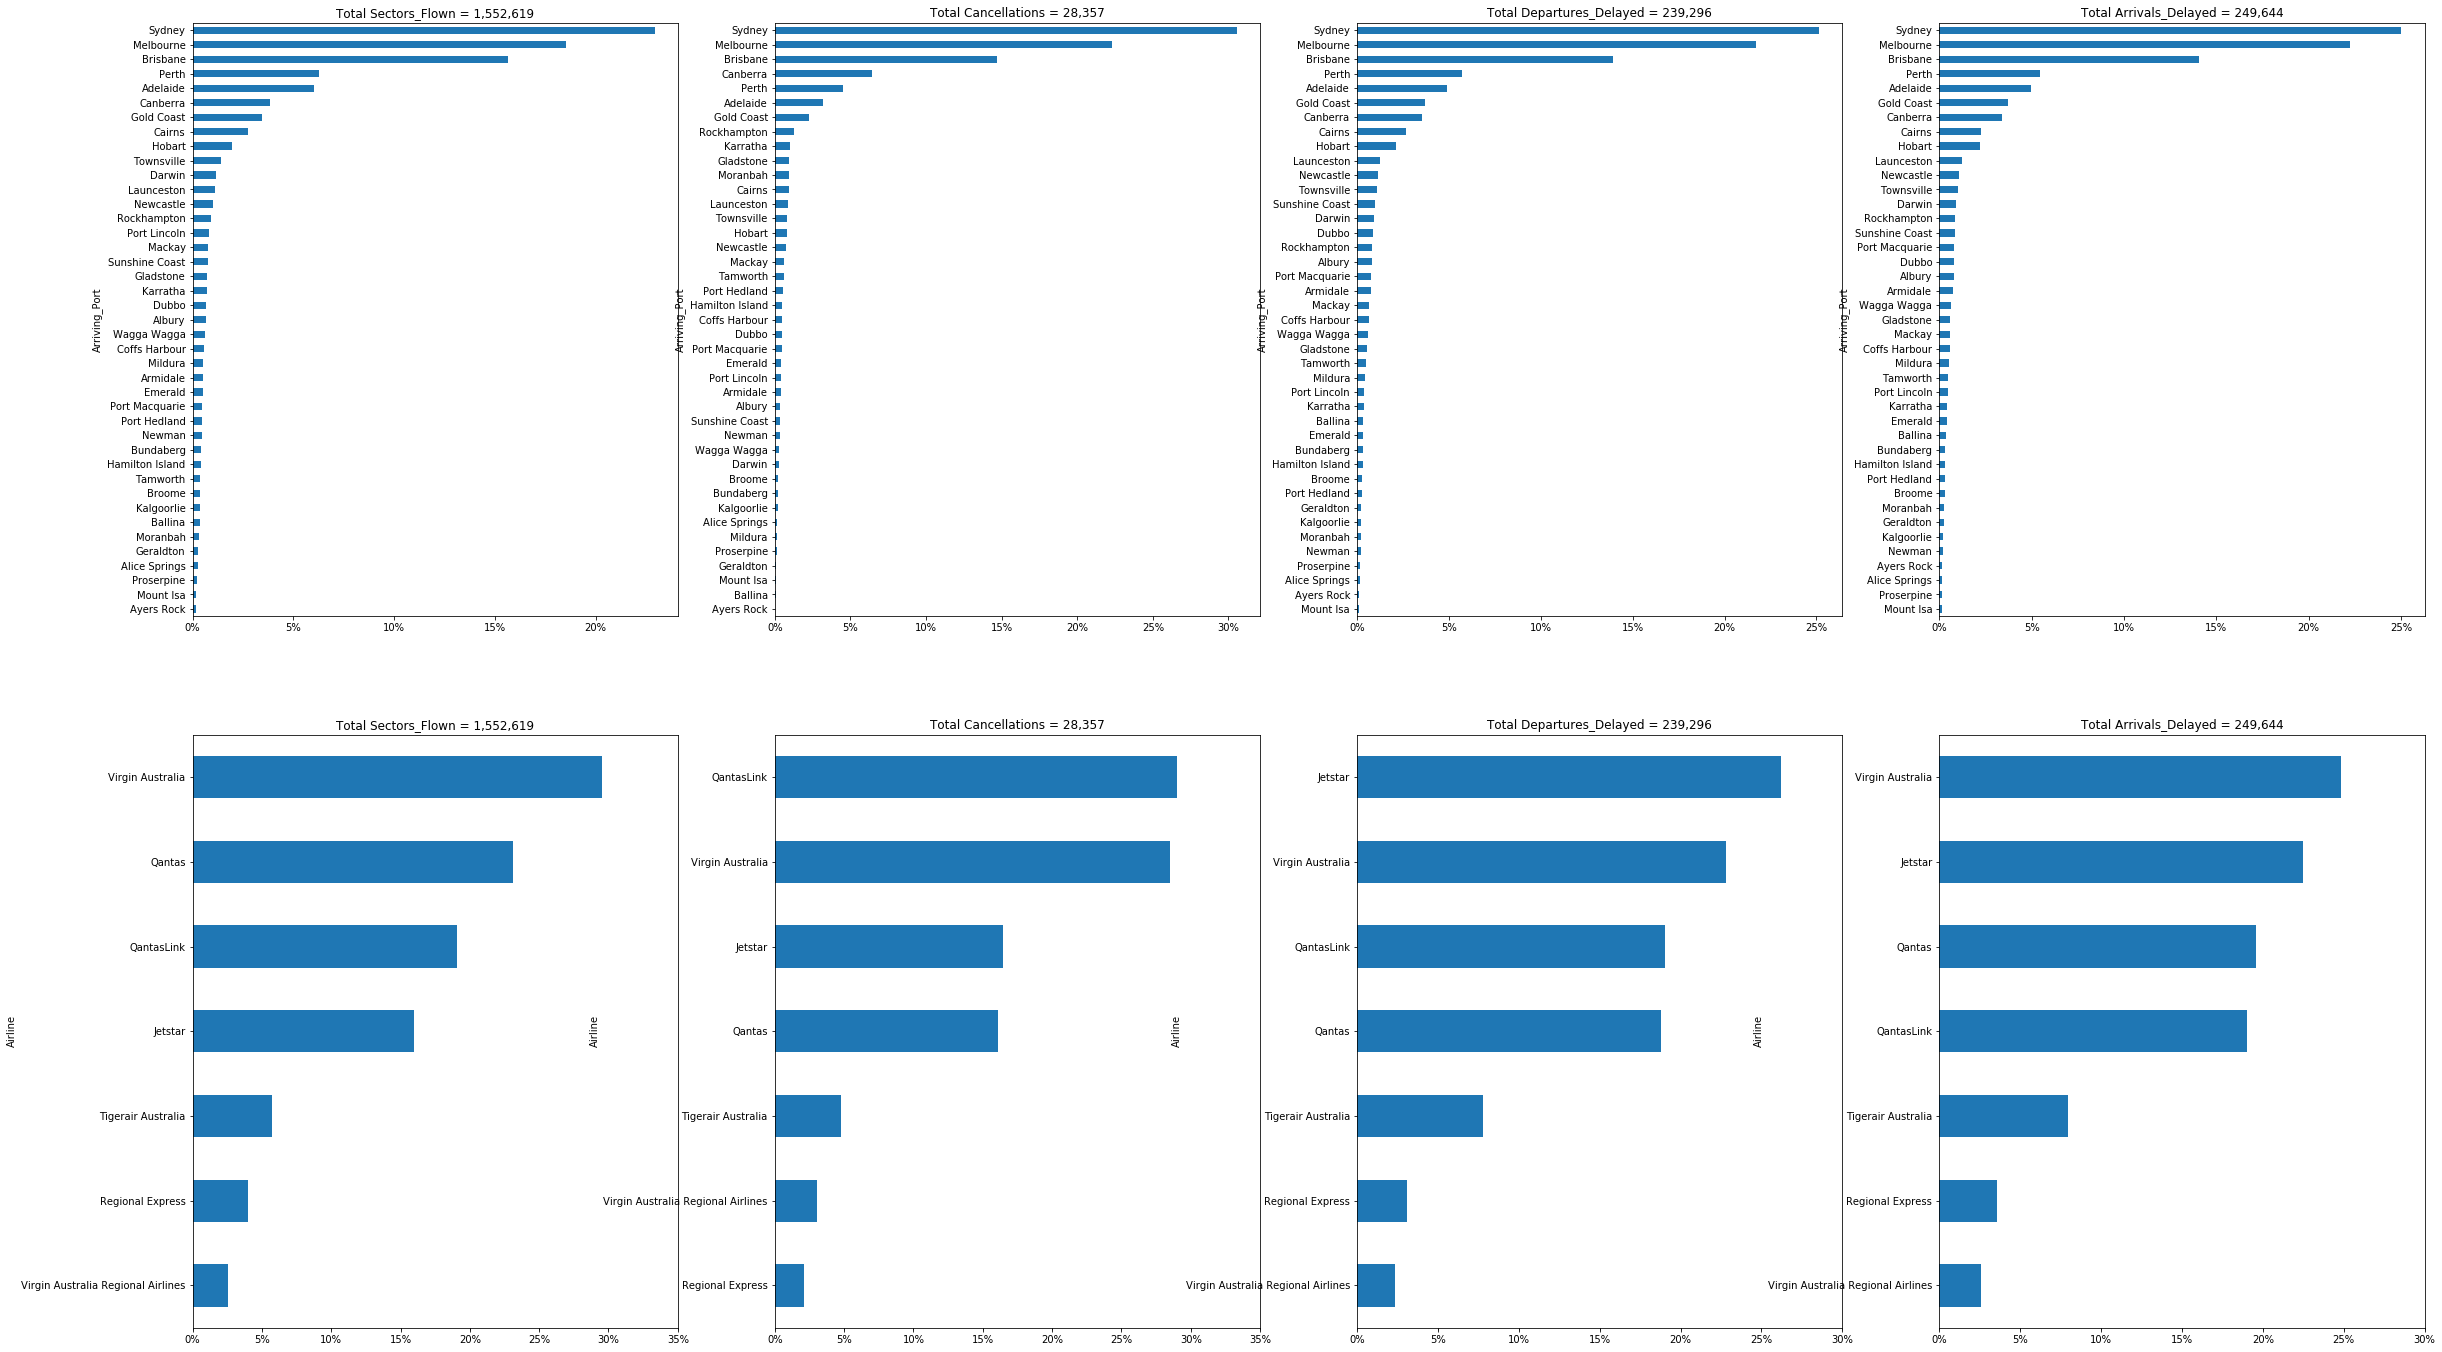

In [14]:
fig, axes = plt.subplots(2,4,figsize=(40,24))

for k,i in enumerate(['Sectors_Flown','Cancellations','Departures_Delayed','Arrivals_Delayed']):

    x=df.groupby('Arriving_Port').sum()[[i]]
    x.sort_values(by=i,ascending=True
                          ).div(x.sum()).plot.barh(title ='Total ' + i + ' = ' + format(int(x.sum()),',d'),
                                      legend=False,
                                      ax=axes[0,k]);
    vals = axes[0,k].get_xticks()
    axes[0,k].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
    
for k,i in enumerate(['Sectors_Flown','Cancellations','Departures_Delayed','Arrivals_Delayed']):

    x=df.groupby('Airline').sum()[[i]]
    ax=x.sort_values(by=i,ascending=True
                          ).div(x.sum()).plot.barh(title ='Total ' + i + ' = ' + format(int(x.sum()),',d'),
                                      legend=False,
                                      ax=axes[1,k]);

    axes[1,k].set_xticks(ax.get_xticks(),minor=True)
   
    vals = axes[1,k].get_xticks()
    
    axes[1,k].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);



We have so far learnt that Sydney, Melbourned and Brisbane are the three highest frequented destinations.

Virgin Australia run 30% of all flights, Quantas 23%. Regional Express run only 3% of flights

We can already start to see airlines that are underperforming. e.g. QuantasLink run 18% of flights but are responsible for 29% of cancellations. Can we visualise more clearly which airlines are underperforming? 

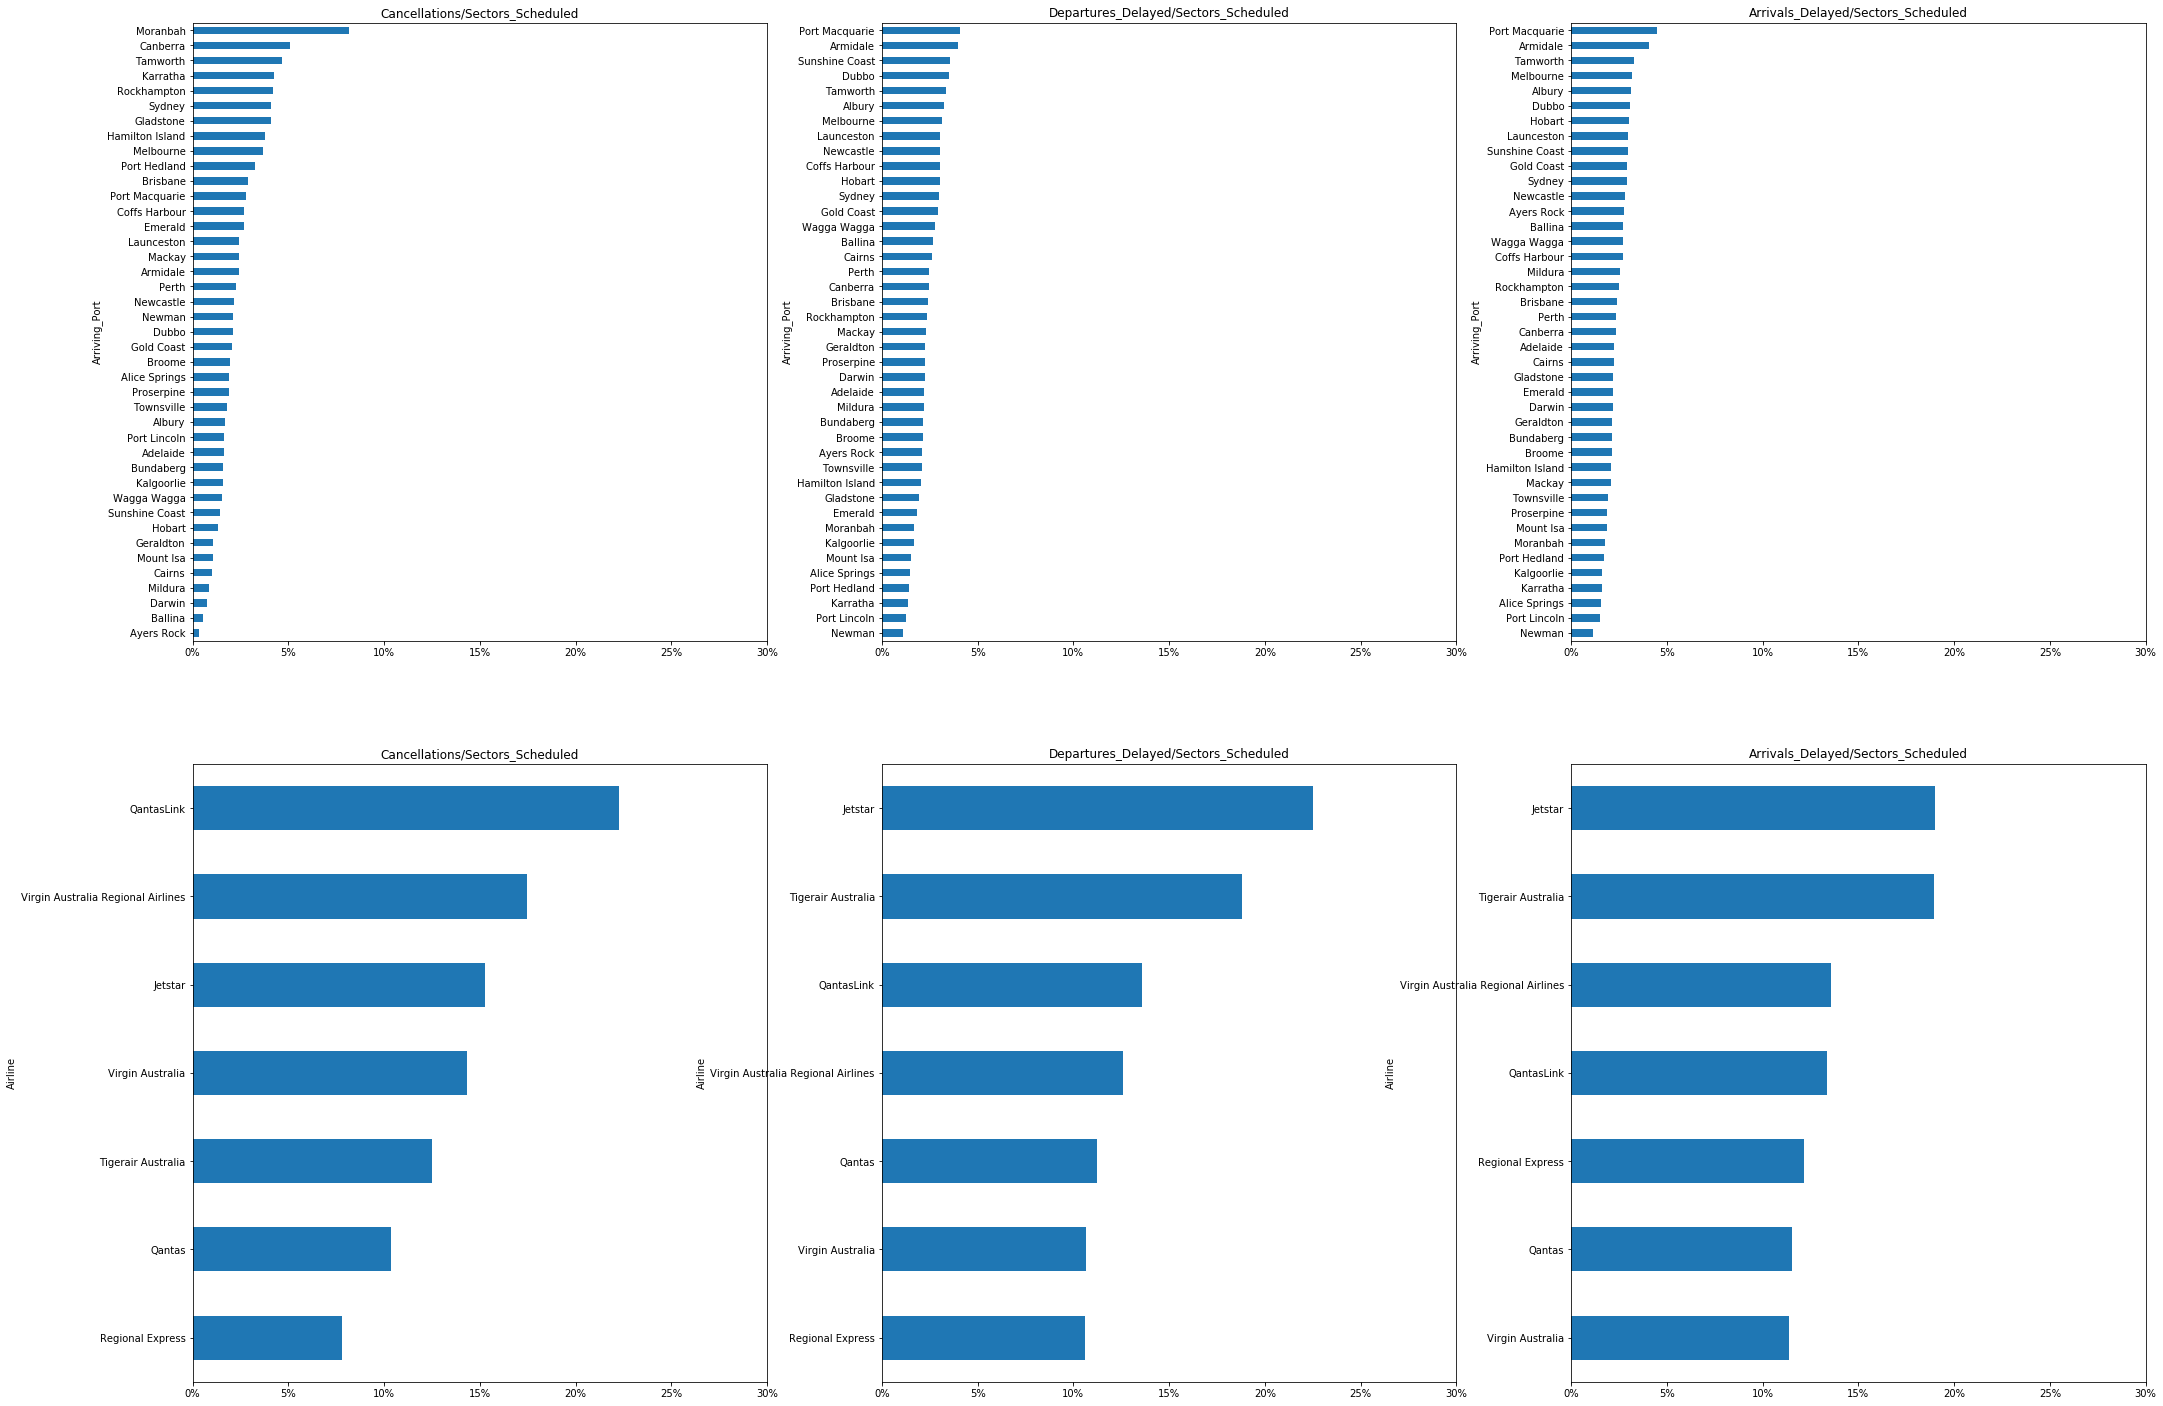

In [15]:
fig,axes = plt.subplots(nrows = 2, ncols = 3,figsize = (35,25))

for k,i in enumerate(['Cancellations','Departures_Delayed','Arrivals_Delayed']):

    x=df.groupby('Arriving_Port').sum()[[i]]
    y= df.groupby('Arriving_Port').sum()[['Sectors_Scheduled']]

    x[i]=x[i]/y['Sectors_Scheduled'].sort_values(ascending = True)
    x.sort_values(by=i,ascending=True
                          ).div(x.sum()).plot.barh(title = i + '/Sectors_Scheduled',
                                      legend=False,
                                      ax=axes[0,k]);
    axes[0,k].set_xticks(ax.get_xticks(),minor=True)

    vals = axes[0,k].get_xticks()

    axes[0,k].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
    
for k,i in enumerate(['Cancellations','Departures_Delayed','Arrivals_Delayed']):
    x=df.groupby('Airline').sum()[[i]]
    y= df.groupby('Airline').sum()[['Sectors_Scheduled']]
    
    x[i]=x[i]/y['Sectors_Scheduled'].sort_values(ascending = True)
    x.sort_values(by=i,ascending=True
                          ).div(x.sum()).plot.barh(title = i + '/Sectors_Scheduled',
                                      legend=False,
                                      ax=axes[1,k]);
    axes[1,k].set_xticks(ax.get_xticks(),minor=True)

    vals = axes[1,k].get_xticks()

    axes[1,k].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

QuantasLink are the worst for cancelled flights, whereas jetstar are the most delayed (both departing and arriving)

Regional Express, despite (or perhaps because of?) being the smallest airline, have the fewest delayed departures and the fewest cancellations.

Ok great. So we've identified how things look overall. However, just because Jetstar has done badly doesn't neccesarily mean its unreliable today. Maybe all their delays occured in 2016 because of a pilot strike but it's actually a great service? How would we know?

Well,lets step back before we get into that and take a holistic view of how things change over time. It's tempting to jump straight into the cancellations and delays but there is already valuable information in how many flights flew every month. This will provide a web of understanding and unanswered questions to build upon.


# How has Sectors_Flown changed over time?

Sectors_Flown will give us a broad understanding of the different airlines, the challenges they face, and the opportunities available to them. 

On to time series data analysis. Let's make a timestamp column first of all so that pandas knows whats going on.

In [16]:
dates=[]
for i in range(num_rows):
    date= str(df.iloc[i]['Year'])+'-'+str(df.iloc[i]['Month_Num']).zfill(2)+'-01'
    dates.append(pd.to_datetime(date))
df['ds']=dates

count       41
mean     37868
std       1474
min      33782
25%      37054
50%      37874
75%      38890
max      40148
Name: Sectors_Flown, dtype: int64

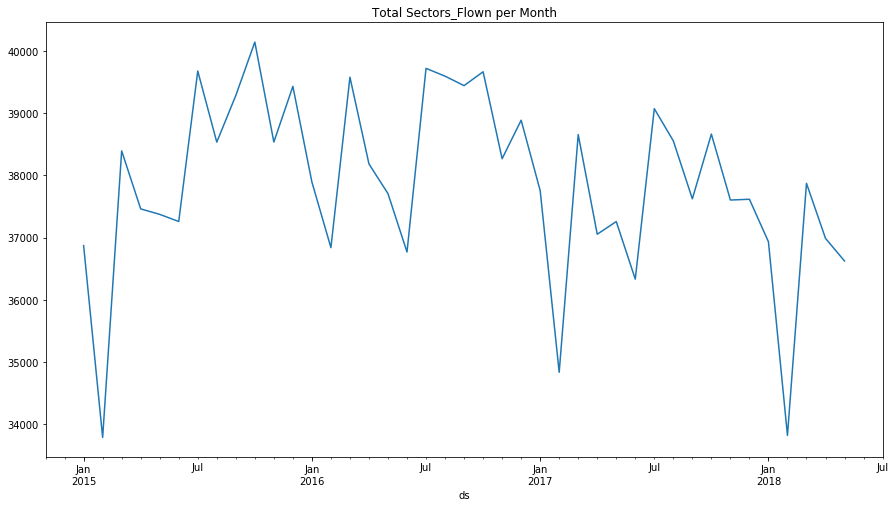

In [17]:
x=df.groupby('ds')['Sectors_Flown'].sum()
x.plot(title='Total Sectors_Flown per Month',figsize=(15,8));
#plt.ylim(30000, 50000); plt.show()
display(x.describe().astype(int));

The graph looks healthy enough, no cataclysmic events in Australian aviation. The average number of flights per month (fpm) is 37,868 and the standard deviation is 3.9% of the mean.

The low was 33,782 fpm in Febrary 2015. The high was 40,148 fpm in October of that same year, a range of 6,366 fpm.

There appear to be dips around February, presumably because of the end of Christmas holidays and the start of the new school year. 

There's clearly some seasonality here. Let's use fbprophet!

# Seasonality of Sectors_Flown

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


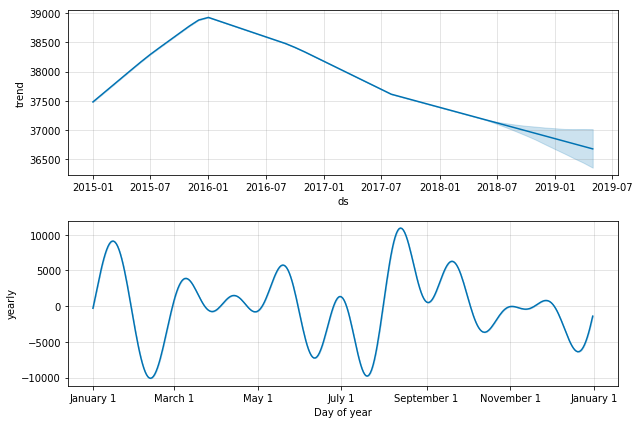

In [18]:
forecast_data = pd.DataFrame({'y':x,'ds':x.index})
m = Prophet()
m.fit(forecast_data)
future = m.make_future_dataframe(periods=12, freq='m')
forecast = m.predict(future)
m.plot_components(forecast);


Overall trend says that total flights are decreasing. Low points are mid-Feb and mid-July. High points are mid-Jan, mid-August.

Why are Aussies flying less? Aussie airlines would want to know because the trend looks set to continue into 2019...

And speaking of airlines, we would want to know how individal airlines have been doing. 

# How many flights per month for each airline?

/Users/Adil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  


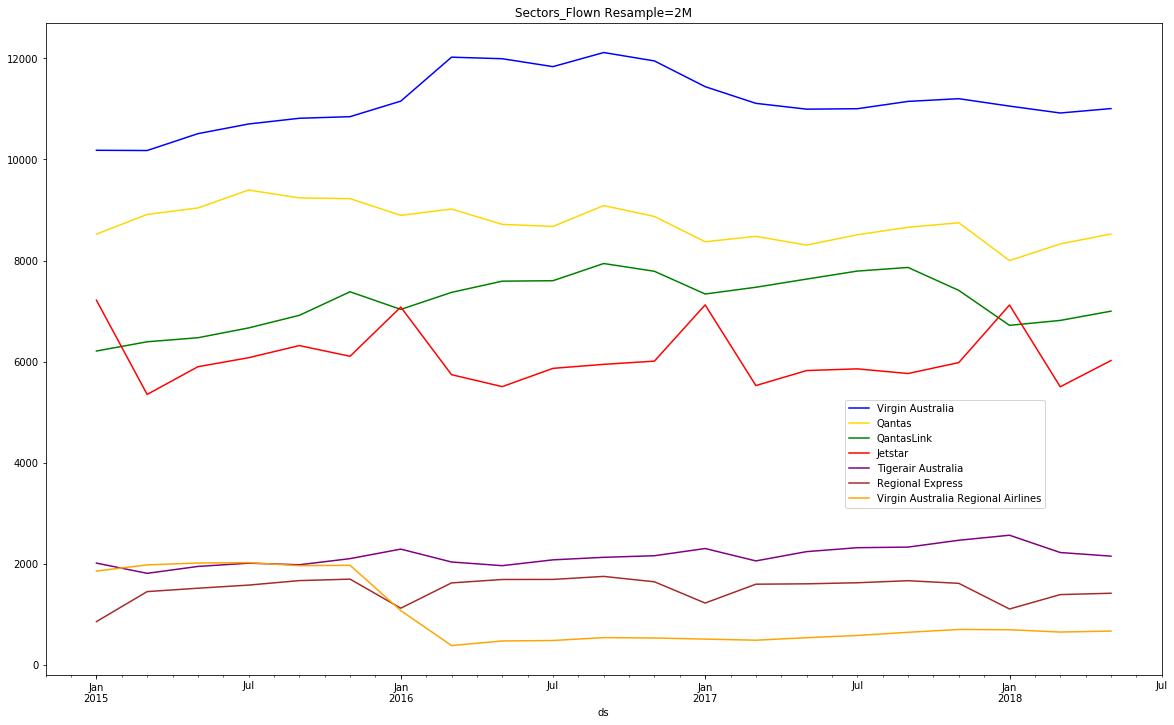

In [19]:
x=df.groupby(['Airline','ds'])

airlines = df.groupby('Airline')['Sectors_Flown'].sum().sort_values(ascending=False).index
colours = ['blue','gold', 'green', 'red', 'purple', 'brown', 'orange']
colour = dict(zip(airlines,colours))

for airline in airlines:
    x['Sectors_Flown'].sum().loc[airline].resample('2M').plot(figsize=(20,12),label=airline,color=colour[airline]);

plt.title('Sectors_Flown Resample=2M')
plt.legend(bbox_to_anchor=(0.9,0.43));

This graph has a lot to tell us.

- The 7 airlines fall into two distinct bands. We have the 4 big airlines: Virgin Australia, Quantas, QuantasLink and Jetstar. Their may have been attempt by each of the 4 to break out of rank but more or loss without success.They all have over 5,000 flights per month. Then we have the likes of Tigerair Australia, Regional Express and Virgin Australia Regional Airlines. We operate significantly fewer - around the 1,500 mark.
- Virgin Australia had a fantastic couple of years betwween 2016 and 2017 but have since lost that momentum. Total flights sampled every 9 months follows the same trend. This tells us that Virgin Australia experienced a boom but hasn't neccesarily lost market share.
- Quantas have been steadily declining. QuantasLink, presumably a daughter company of Quantas has taken up that lost market share.
- Jetstar has the most well defined seasonality. During the Christmas/Summer holidays, they operate perhaps a 1,000 more flights than during the rest of the year. From the name, and the seasonality, and the fact that they run the fewest flights of the big 4, my hunch is that they are a budget airline, most comparable to easyJet. 
- Tigerair is, well, the tiger of its bunch. Their growth is slow but steady.
- Regional express exhibits the opposite trend to Jetstar. Their low occurs precisely during Jetstars high. Is Jetstar undercutting Regional Express during the high season?
- Virgin Australia Regional Airlines is clearly the loser. Starting at the top of the pack in 2015  with 2,000 flights per month, their volume ramped down quite dramatically over Summer 2016, just at the same time Virgin Australia was booming. The two companies are obviously related and the change looks like a step change, so this has probably been intentional.

Regional flights are starting to look more interesting, and we have the data to look into that! How can we classify routes as regional or not regional? What does regional even mean?

# Regional vs Non-Regional?

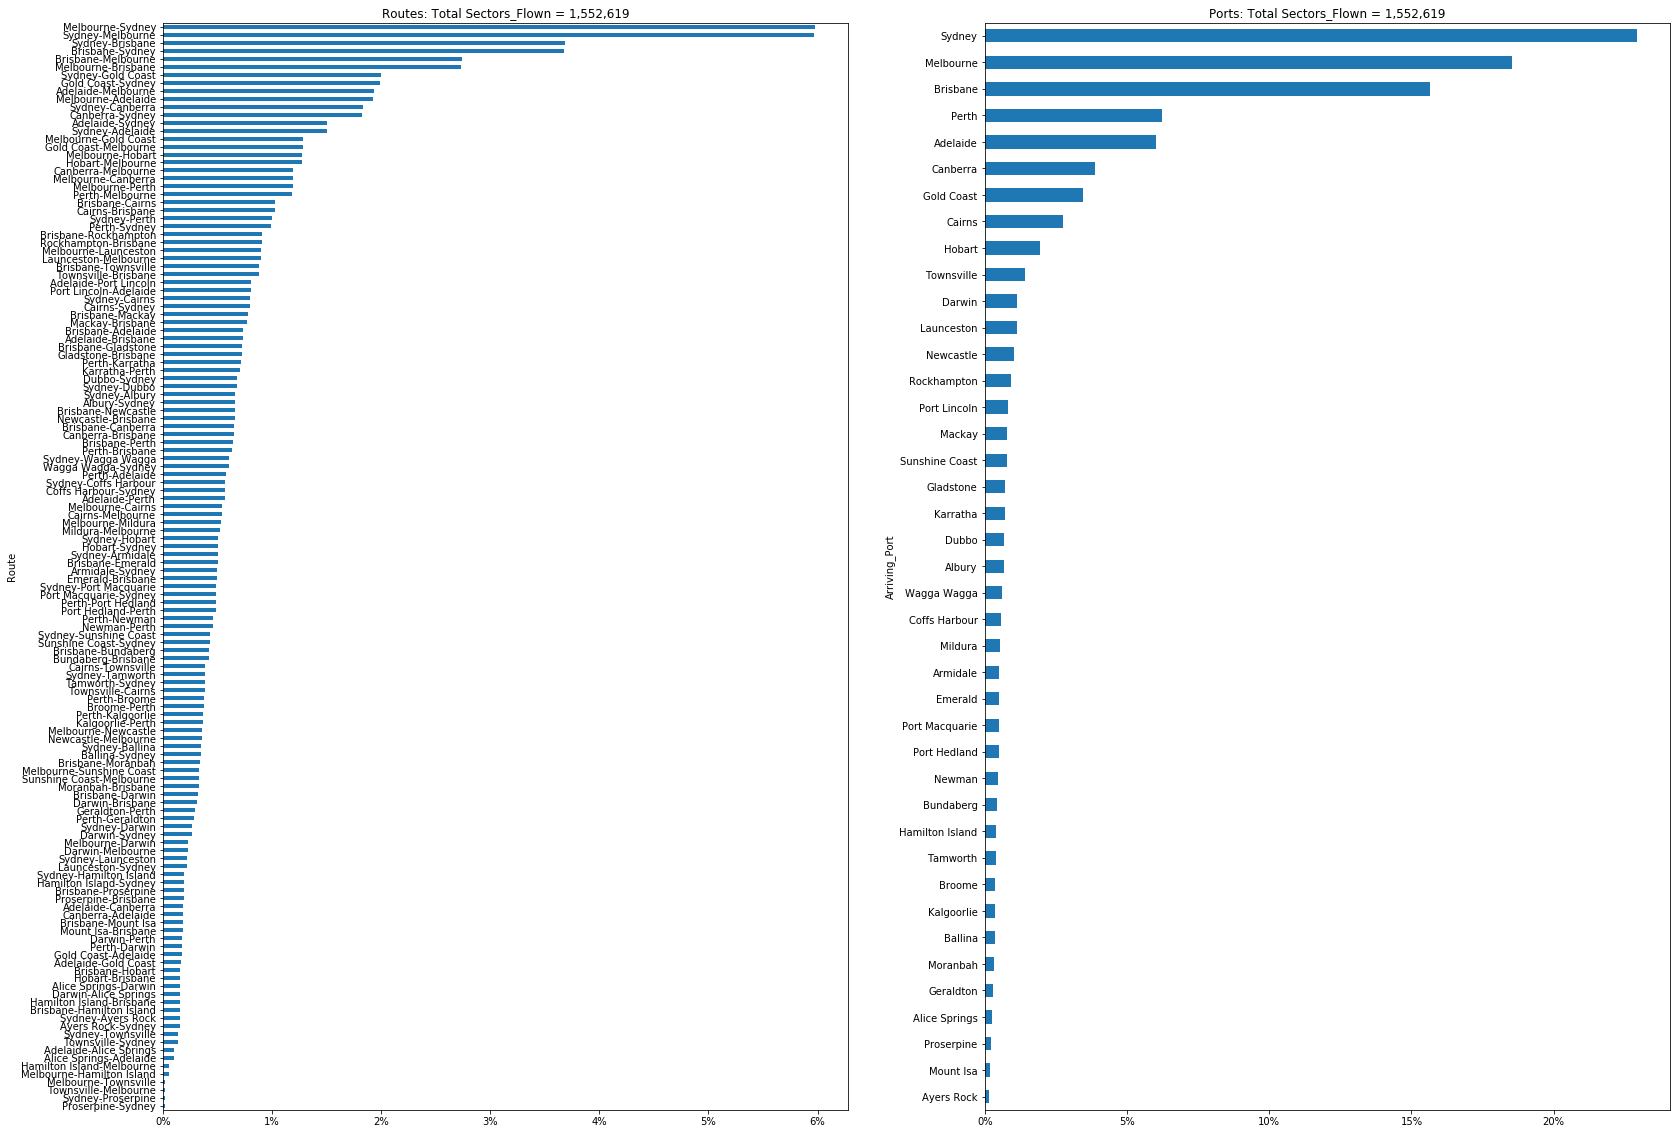

In [20]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(27,20))

i='Sectors_Flown'

x=df.groupby('Route').sum()[[i]]
x.sort_values(by=i,ascending=True
                      ).div(x.sum()).plot.barh(title ='Routes: Total ' + i + ' = ' + format(int(x.sum()),',d'),
                                  legend=False,
                                  ax=axes[0]);
vals = axes[0].get_xticks()
axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

x=df.groupby('Arriving_Port').sum()[[i]]
x.sort_values(by=i,ascending=True
                      ).div(x.sum()).plot.barh(title ='Ports: Total ' + i + ' = ' + format(int(x.sum()),',d'),
                                  legend=False,
                                  ax=axes[1]);
vals = axes[1].get_xticks()
axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
    


The top few, between Sydney, Melbourne, Brisbane are definitely not regional flights.

My knowledge of Australia is severly limited which means that if I recognise a city, then it's probably not "regional". 
12% of flight go between Melbourne and Sydney
1.4% of flights go between Brisbane and Adelaide
0.34% of flights go between Adelaide and Gold Coast 	
0.30% of flights go between Hamilton Island and Brisbane

Neither Adelaide nor Gold Coast are regional loctions, but it's just an unpopular route. So it won't work to classify routes as regional/non-regional based upon how often they are used.

Let's instead take the ports most frequently used: 'Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Canberra','Gold Coast', 'Cairns', 'Hobart'.

If a route involves BOTH of these routes then it is non-regional else it is regional. There. Done. We can add a new column to classify flights. 1 = regional, 0 = non-regional
       
       

In [21]:
cities = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Canberra','Gold Coast', 'Cairns', 'Hobart']
regional = []
for i in range(num_rows):
    if df.iloc[i]['Departing_Port'] in cities and df.iloc[i]['Arriving_Port'] in cities:
        regional.append(0)
    else:
        regional.append(1)
df['Regional'] = regional


In [22]:
print('Number of regional routes = %d'
      %df.groupby("Route").mean()['Regional'].sum())

print('Number of non-regional routes = %d'
      %(df.groupby("Route").mean()['Regional'].count()-df.groupby("Route").mean()['Regional'].sum()))

print('\nNumber of regional flights = %s'
      %"{:,}".format(df.groupby('Regional').sum()['Sectors_Flown'].loc[1]))

print('Number of non-regional flights = %s'
      %"{:,}".format(df.groupby('Regional').sum()['Sectors_Flown'].loc[0]))

print('\nFlights per route (regional) = %s'
      %"{:,}".format(int(df.groupby('Regional').sum()['Sectors_Flown'].loc[1]/df.groupby("Route").mean()['Regional'].sum())))

print('Flights per route (non-regional) = %s'
      %"{:,}".format(int(df.groupby('Regional').sum()['Sectors_Flown'].loc[0]/(df.groupby("Route").mean()['Regional'].count()-df.groupby("Route").mean()['Regional'].sum()))))


Number of regional routes = 90
Number of non-regional routes = 46

Number of regional flights = 572,440
Number of non-regional flights = 980,179

Flights per route (regional) = 6,360
Flights per route (non-regional) = 21,308


As we might expect, there are more regional routes than non-regional, but non-regional routes recieve about 3 times more traffic than regional routes. Here's a map to illustrate this

In [23]:
au=pd.DataFrame(df.groupby('Departing_Port').sum()['Sectors_Scheduled'])

lats=[]
longs=[]

geolocator = Nominatim(user_agent="none")
for port in au.index:
    location = geolocator.geocode(port+ ', Australia')
    lats.append(location.latitude)
    longs.append(location.longitude)
        
def LongLat_to_EN(long, lat):
        easting, northing = transform(
        Proj(init='epsg:4326'), Proj(init='epsg:3857'), long, lat)
        return easting, northing
coordsEN=[LongLat_to_EN(longs[i],lats[i]) for i in range(len(au))]
x = [coordsEN[i][0] for i in range(len(coordsEN))]
y =[ coordsEN[i][1] for i in range(len(coordsEN))]

au['lats'],au['longs']=lats,longs
au['x'],au['y']=x,y
au['Departing_Port']=au.index
au['legend'] = ['non-regional' if i in cities else 'regional' for i in au.index]
au['fill_color'] = ['green' if i in cities else 'red' for i in au.index]
au['fill_alpha'] = [0.2 if i in cities else 1 for i in au.index]
au['size']=au['Sectors_Scheduled'].div(1500)

source=ColumnDataSource(au)

p = figure(x_range=(1.23e7, 1.8e7), y_range=(-1e6, -6e6),
           x_axis_type="mercator", y_axis_type="mercator",
           plot_width=1000, plot_height=1000)
p.title.text='Total Scheduled Flights in Australia 2015-2018'
p.add_tile(CARTODBPOSITRON)

p.circle(x='x', y='y', size='size',source=source,fill_color="fill_color",fill_alpha='fill_alpha',legend='legend')

labels = LabelSet(x='x', y='y', text='Departing_Port', level='glyph',source=source, render_mode='canvas')
p.add_layout(labels)

show(p)

# How does regionality affect flights per month for each airline?

Now let's run look again at how each airline has performed over time, once for regional and again for non-regional.

In [24]:
def totals(var, resample = 'M', title = 'TITLE',regional=0, y_range = [0,1], plot_width=800, plot_height=600) :

    p = figure(plot_width=plot_width, plot_height=plot_height, x_axis_type="datetime",y_range=y_range)
    p.title.text = var  + (' (Regional)' if regional==1 else ' (Non-regional)' )+ ' Resample='+resample

    x=df[df['Regional']==regional].groupby(['Airline','ds']).sum()
    y=x[var]
    data_out = y

    airlines = df[df['Regional']==regional].groupby('Airline')[var].sum().sort_values(ascending=False).index

    for airline in airlines:
        data = y.loc[airline].resample(resample).mean()
        p.line(data.index,data,line_width = 2,color=colour[airline],legend=airline)

    x=df[df['Regional']==regional].groupby(['ds','Airline']).sum()
    y=x[var]
    data = y.groupby('ds').mean().resample(resample).mean()
    p.line(data.index,data,line_width = 2,color='grey',legend='Average Airline')

    x=df[df['Regional']==regional].groupby(['ds']).sum()
    y=x[var]
    data = y.groupby('ds').mean().resample(resample).mean()
    p.line(data.index,data,line_width = 2,color='black',legend='Grand Total')

    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    p.legend.label_text_font_size = "12pt"
    p.legend.background_fill_alpha = 0

    return p,data_out
p0,d0 = totals('Sectors_Flown', resample = '2M', title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,10000])
p1,d1 = totals('Sectors_Flown', resample = '2M', title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,10000])

show(row(p0,p1))

The plot thickens. Now we can really start to understand the pressures these airlines face from eacho other.

The big 4 have more flights operating between the cities identified as non-regional. Non-regional flights looks quite calm, nothing major, although interesting that Virgin Australia Regional Airlines abandoned Non-regional flights for a year and a half and Tigerair has avoided that Non-regional flights completely.

Before it seemed that Virgin Australia was untouchable, but these two graphs tell a different story. With regional flights, QuantasLink destroys Virgin Australia. Quantas opeate relatively few regional flights but in Non-regional flights they are neck-to-neck with VA, although never quite beating then.

So we can see some of their strategy now. VA are everywhere but they focus much more on non-regional flights. Quantas and QuantasLink together pose a strong threat to VA.  

Bang in the middle of Non-regional flights we have Jetstar bobbing along. They've evidently carved a niche for themselves, seen by the space above and below. They've also got room to manoevre with high highs and low lows. It's quite a different matter for regional flights however. They perfectly mirror Regional Express, although Regional Express is on the wrong side of the mirror. Every winter Jetstar steals their Winter customers, a strategy that is sure to whittle them down. The Winter is a very important time therefore for Jetstar. If they want to retain their stolen customers they have to be kept sweet which means as few delays/cancellations as possible.

Regional Express, don't run a single Non-regional route, which means we picked our non-regional cities well. They've got their hands full fighting off Jetstar anyway.

Virgin Australia Regional Airlines. Have they given up? They certainly gave up on Non-Regional routes. Why did they bother starting them up again in October 2017? VA is engulfing them in the Regional routes. It's not clear what Virgin is doing here. 

Tigerair Australia, I'm quite curious about these guys. They're small but clearly on the up. They're not interested in the regional routes- -that market is saturated by QuantasLink, VA, the small regional companies. But perhaps they've spotted the gap in the market currently occupied by Jetstar for budget airlines? Are the tigers here to stay?


So. We've learned a bit more about our airline, who they are and where they fly. We've learnt that:
- Jetstar and Regional Airlines are fighting for Regional routes, Jetstar emerge victorious every xmas. 
- Tigerair is out to dethrone Jetstar's budget Non-regional routes
- Quantas/QuantasLink fight a complex battle with VA on both fronts
- Virgin Australia Regional Airlines are a waste of space
- Summer/Xmas is a contentious time.
- Airlines started making some changes, or reacting to changes, in January 2016, but by mid-2017 things had settled down.

Now that we are better informed, we can get see what delays and cancellations are doing.

# How have airlines' cancellation rate changed over time?

 Let's get a broad look at cancellations. Our KPI will be the percentage of flights sceduled that are cancelled (cf).
 
I want to be able to compare cf fom each airline with time on the x axis. I want a line as well for the average of each of those (not the total average, I want to give each airline equal weighting). Is this affected by whether flight is regional/non-regional?
 
 The graph is going to look complicated, but we can use Bokeh instead which allows us to hide/show airlines as we please. 
 


In [25]:
def cancellations(resample = 'M', title = 'TITLE',regional=0, y_range = [0,1], plot_width=800, plot_height=600) :



    p = figure(plot_width=plot_width, plot_height=plot_height, x_axis_type="datetime",y_range=y_range)
    p.title.text = 'Cancellation Rate'+ (' (Regional)' if regional==1 else ' (Non-regional)' )+ ' Resample='+resample

    x=df[df['Regional']==regional].groupby(['Airline','ds']).sum()
    y=x['Cancellations']/x['Sectors_Scheduled']
    data_out = y

    airlines=(df[df['Regional']==regional].groupby('Airline').sum()['Cancellations']/df[df['Regional']==regional].groupby('Airline').sum()['Sectors_Scheduled']).sort_values(ascending=False).index

    for airline in airlines:
        data = y.loc[airline].resample(resample).mean()
        p.line(data.index,data,line_width = 2,color=colour[airline],legend=airline)

    x=df[df['Regional']==regional].groupby(['ds','Airline']).sum()
    y=x['Cancellations']/x['Sectors_Scheduled']
    data = y.groupby('ds').mean().resample(resample).mean()
    p.line(data.index,data,line_width = 2,color='grey',legend='Average Airline')

    x=df[df['Regional']==regional].groupby(['ds']).sum()
    y=x['Cancellations']/x['Sectors_Scheduled']
    data = y.groupby('ds').mean().resample(resample).mean()
    p.line(data.index,data,line_width = 2,color='black',legend='Average All')

    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    p.legend.label_text_font_size = "12pt"
    p.legend.background_fill_alpha = 0
    p.yaxis.formatter=NumeralTickFormatter(format="0%")
    
    return p,data_out

resample = 'Q'
plot_width=1000
plot_height=600

p0,d0 = totals('Sectors_Flown', resample = resample, title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,10000],plot_width=plot_width,plot_height=plot_height)
p1,d1 = totals('Sectors_Flown', resample = resample, title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,10000],plot_width=plot_width,plot_height=plot_height)

p2,d2 = cancellations(resample = resample, title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,0.1],plot_width=plot_width,plot_height=plot_height)
p3,d3 = cancellations(resample = resample, title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,0.1],plot_width=plot_width,plot_height=plot_height)

show(column(row(p0,p1),
            row(p2,p3)))


Right, what can we make of this?
The legend is ordered by average cancellation rate. So Quantas has the highest cancellation rate while QuantasLink has the lowest.

Regional flights seem to have fewer cancellations than Non-regional. Non-regional cancellations has been quite the rollercoaster.

We can see spikes in cancellations occur simultaneously for several airlines. Non-regional flights in October 2017 sees a spike for every airline. What happened??? This coincides with a significantly fall in regional Quantas flights. Similarly a spike occured for Regional flights in March 2017

Filter by Quantas, QuantasLink, Average.

Remember: Quantas specialise in non-regional and QuantasLink speacialise in regional flights, so while QuantasLink Non-regional looks disastrous, it's not that bad because they run significantly fewer non-regional flights. Still, while QuantasLink Regional manages to keep below 4%, it's done miserably compared to the other regional routes. It's a whole different story with Quantas.  They've kept under 2% (ignoring Oct 17). They operate a much more reliable service than Link. This can be explained by the fact that QuantasLink have been growing rapidly - between 2015 and 2017 their fpm increased by over 1000. With such expansion it's understandable that they would run into difficulties (although 10% cancellations is ridiculous). In contrast, Quantas is the more mature and reliable parent.


Filter by Jetstar and VA. 

This is interesting because the graphs look quite similar. For regional flights, the both had a spike around March 2017. Why? This is normally a calm time of year. Non-regional Jetstar spikedto 5% cancellations in January 2016. This makes a bit more sense, as Christmas is a busy time of the year. In January 2017 Non-regional Jetstar spikes again - but only to 3%. And then then January 2018 it cancellations stay under 2%. Well done Jetstar!

We knew already that VA started pushing hard from Jan 16 - Jan 17. Their cancellation rate went up during this time which means they may have bitten off more than they could chew. Could this be why they scaled back down after this period?

Filter by Tigerair, Average.

Non-regional flights have done alright. The Tigers keep below average until Octo 17, at which point they coincide with the average. Tigerair don't operate many regional flights so it doesn't need to concern us. 

We can look further into cancellations later. Now I would like to do the same thing for delays in arrivals/departures.


# How have delays changed over time for each airline ?


In [26]:
def delays(var, resample = 'M', title = 'TITLE',regional=0, y_range = [0,1], plot_width=800, plot_height=600) :


    p = figure(plot_width=plot_width, plot_height=plot_height, x_axis_type="datetime",y_range=y_range)
    p.title.text = var+ ' Rate' +'\t' + (' (Regional)' if regional==1 else ' (Non-regional)' )+'\t'+ ' Resample='+resample

    x=df[df['Regional']==regional].groupby(['Airline','ds']).sum()
    y=x[var]/x['Sectors_Flown']
    data_out = y

    airlines=(df[df['Regional']==regional].groupby('Airline').sum()[var]/df[df['Regional']==regional].groupby('Airline').sum()['Sectors_Flown']).sort_values(ascending=False).index

    for airline in airlines:
        data = y.loc[airline].resample(resample).mean()
        p.line(data.index,data,line_width = 2,color=colour[airline],legend=airline)

    x=df[df['Regional']==regional].groupby(['ds','Airline']).sum()
    y=x[var]/x['Sectors_Flown']
    data = y.groupby('ds').mean().resample(resample).mean()
    p.line(data.index,data,line_width = 2,color='grey',legend='Average Airline')
        
    x=df[df['Regional']==regional].groupby(['ds']).sum()
    y=x[var]/x['Sectors_Flown']
    data = y.groupby('ds').mean().resample(resample).mean()
    p.line(data.index,data,line_width = 2,color='black',legend='Average All')

    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    p.legend.label_text_font_size = "12pt"
    p.legend.background_fill_alpha = 0
    p.yaxis.formatter=NumeralTickFormatter(format="0%")

    return p, data_out


resample = 'Q'
plot_width,plot_height = 1200,600

p0,d0 = totals('Sectors_Flown', resample = resample, title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,10000],plot_width=plot_width,plot_height=plot_height)
p1,d0 = totals('Sectors_Flown', resample = resample, title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,10000],plot_width=plot_width,plot_height=plot_height)

p4,d4 = delays('Departures_Delayed', resample = resample, title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)
p5,d5 = delays('Departures_Delayed', resample = resample, title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)

p6,d6 = delays('Arrivals_Delayed', resample = resample, title = 'Arrival Delays (%) (Non-regional)',regional=0, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)
p7,d7 = delays('Arrivals_Delayed',  resample = resample, title = 'Arrival Delays (%) (Regional)',regional=1, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)

show(column(row(p0,p1),
            row(p4,p5),
            row(p6,p7)))



First of all, graphs, for delayed arrivals and delayed departures look like they have a high correlation.

In general, flights are getting more delayed, In 2015 14% of flights were delayed, this figure rose to 19% in 2017 and stands at 17% in 2018

Airlines all seem to suffer delays at the same time, indicating that to some extent airlines are not in control of the rate of delays, e.g. weather.

For regional flights, Quantas was the least delayed. For Non regional flights VA was the least delayed

Jetstar is by far the most delayed for Regional flights. For Non-regional flights Jetstar were the most delayed until they were surpassed by Tigerair in July '17.



# Is there a yearly fluctuation in delays/cancellations?
If I'm an airline manager, I want to know when in the year I can expect delays and cancellations to happen in the future so that I can start to plan for - and reduce - them.

In [27]:
resample = 'M'
p0,d0 = totals('Sectors_Flown', resample = resample, title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,10000],plot_width=plot_width,plot_height=plot_height)
p1,d1 = totals('Sectors_Flown', resample = resample, title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,10000],plot_width=plot_width,plot_height=plot_height)
p2,d2 = cancellations(resample = resample, title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,0.1],plot_width=plot_width,plot_height=plot_height)
p3,d3 = cancellations(resample = resample, title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,0.1],plot_width=plot_width,plot_height=plot_height)
p4,d4 = delays('Departures_Delayed', resample = resample, title = 'Departure Delays (%) (Non-regional)',regional=0, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)
p5,d5 = delays('Departures_Delayed', resample = resample, title = 'Departure Delays (%) (Regional)',regional=1, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)
p6,d6 = delays('Arrivals_Delayed', resample = resample, title = 'Arrival Delays (%) (Non-regional)',regional=0, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)
p7,d7 = delays('Arrivals_Delayed',  resample = resample, title = 'Arrival Delays (%) (Regional)',regional=1, y_range=[0,0.5],plot_width=plot_width,plot_height=plot_height)


In [38]:
def season(d,airline):
    global df_y
    m = Prophet(weekly_seasonality=False,daily_seasonality=False)
    try:
        x=d.loc[airline]
        forecast_data = pd.DataFrame({'y':x,'ds':x.index})
        m.fit(forecast_data)

        yearly_start = 0
        days = (pd.date_range(start='2000-01-01', periods=365) +
                    pd.Timedelta(days=yearly_start))
        df_y = seasonality_plot_df(m, days)
        seas = m.predict_seasonal_components(df_y)
        x_axis=df_y['ds'].dt.to_pydatetime()
        return seas['yearly']
    except:
        return None



In [41]:
sources=[]
yearly_start = 0
days = (pd.date_range(start='2000-01-01', periods=365) +
            pd.Timedelta(days=yearly_start))
df_y = seasonality_plot_df(m, days)
x_axis = df_y['ds'].dt.to_pydatetime()

for airline in airlines:
    source=pd.DataFrame({'x_axis':x_axis,
                      'canNR':season(d2,airline),'canR':season(d3,airline),
                      'depNR':season(d4,airline),'depR':season(d5,airline),
                      'arrNR':season(d6,airline), 'arrR':season(d7,airline)})
    sources.append(source)

sources = dict(zip(airlines,sources))

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 16.0.
/Users/Adil/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 16.0.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 16.0.


In [47]:
#fig = plt.figure(facecolor='w', figsize=(10, 6))
#ax = fig.add_subplot(111)
#ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
#months = MonthLocator(range(1, 13), bymonthday=1, interval=2)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos=None: '{dt:%B} {dt.day}'.format(dt=num2date(x))))
#ax.xaxis.set_major_locator(months)
#ax.set_xlabel('Day of year')
#ax.set_ylabel('yearly')
#x_axis=df_y['ds'].dt.to_pydatetime()


#plt.plot(x_axis, season(d2,'Qantas'));
#plt.plot(x_axis, season(d3,'Qantas'));
#plt.plot(x_axis, season(d4,'Qantas'));
#plt.plot(x_axis, season(d5,'Qantas'));
#plt.plot(x_axis, season(d6,'Qantas'));
#plt.plot(x_axis, season(d7,'Qantas'));



In [ ]:
airline = 'Regional Express'
source=sources[airline]

p = figure(plot_width=plot_width, plot_height=plot_height, x_axis_type="datetime")
p.title.text = airline
p.line('x_axis','canR',source=source,legend='Cancellations (Regional)',color='red')
p.line('x_axis','canNR',source=source,legend='Cancellations (Non-regional)',color='green')
p.line('x_axis','depR',source=source,legend='Departures (Regional)',color='blue')
p.line('x_axis','depNR',source=source,legend='Departures (Non-regional)',color='orange')

p.line('x_axis','arrR',source=source,legend='Arrivals (Regional)',color='purple')
p.line('x_axis','arrNR',source=source,legend='Arrivals (Non-regional)',color='brown')

p.legend.location = "top_left"
p.legend.click_policy="hide"
p.legend.label_text_font_size = "12pt"
p.legend.background_fill_alpha = 0
p.yaxis.axis_label = '% of Scheduled'
p.xaxis.formatter = DatetimeTickFormatter(months="%B")
#show(p)

In [34]:
def make_plot(airline):
    
    source = sources[airline]
    p = figure(plot_width=plot_width, plot_height=plot_height, x_axis_type="datetime")
    p.title.text = airline
    p.line('x_axis','canR',source=source,legend='Cancellations (Regional)',color='red')
    if airline != 'Virgin Australia Regional Airlines':
        p.line('x_axis','canNR',source=source,legend='Cancellations (Non-regional)',color='green')
    p.line('x_axis','depR',source=source,legend='Departures (Regional)',color='blue')
    p.line('x_axis','depNR',source=source,legend='Departures (Non-regional)',color='orange')
    p.line('x_axis','arrR',source=source,legend='Arrivals (Regional)',color='purple')
    p.line('x_axis','arrNR',source=source,legend='Arrivals (Non-regional)',color='brown')

    p.legend.location = "top_left"
    p.legend.click_policy="hide"
    p.legend.label_text_font_size = "12pt"
    p.legend.background_fill_alpha = 0
    p.yaxis.axis_label = '% of Scheduled'
    p.xaxis.formatter = DatetimeTickFormatter(months="%B")
    p.yaxis.formatter=NumeralTickFormatter(format="0%")

    return p


In [45]:
for airline in airlines:
    show(make_plot(airline))

# Conclusions

So, we've been able to broadly characterise the differents airlines. VA, Qantas and QantasLink are large and reliable. Jetstar is quite big but also unreliable, so probably low cost. The rest are small airlines. 

Some airlines operate regionally - QantasLink, Regional Express, Virgin Australia Regional Airlines 
some non-regionally - Qantas, Tigerair Australia,
and some both - VA, Jetstar

### Virgin Atlantic, Qantas, QantasLink

VA is the largest airline overall, however non-regionally they are rivalled by Qantas and regionally they are dominated by QuantasLink.

At the start of 2016, QantasLink and VA ramped up. Qantas had slightly fewer flights. This suggests intensified competition between the two for regional flight. 

In terms of delays cancellations, VA tend to be the most reliable, closely followed by Qantas, however QuantasLink consistently has an above average rate of cancellations/delays.

A VA flight is most likely to be cancelled in mid-June, Qantas in September, QuantasLink in October. QantasLink is more reliable in May.

A VA flight is 5% more likely to be dealyed in July, 4% in mid-March and most reliable in late-January. Qantas is most delayed in early July and the least in late-Jan. QantasLink is at its worst in July but most reliable in early-Jan and late-April.

Non-regional QantasLink is incredibly unreliable. Their flight numbers are not huge but they are consistent. That said every xmas their volume decreases, suggesting better flight deals from their competitors at this time of year. Time to drop QantasLink non-regional and invest more in Qantas non-regional and QantasLink regional? 

### Jetstar

Jetstar have carved out a niche for themselves, I'm guessing they are a budget airline and the most similar to easyJet. They operate twice as many non-regional as regional flights. They experience significant peaks during the summer holidays. 

Their cancellation rate has steadily improved. They have a serious issue with delays. Since 2017 that has improved and they are no longer the worst.

Their cancellations peak in late-Nov and are the lowest in March.

Their dealys are the worst in July and their best in mid-July, rather odd since their traffic is the lowest in July. What's causing this drastic change?


### Tigerair Australia

An airline that is truly living up to it's name. They appear to be trying to compete with Jetstar, in fact moving slowly but surely on their territory. It hasn't been smooth though, their delays/cancellations have been getting ever more out of control, suggesting difficulties coping with growth. They operae exclusively non-regionally. They are likely to also be a low cost carrier. 

### Virgin Atalantic Regional Airlines, Regional Express

VA Regional - perhaps VA's answer to QantasLink? - it's numbers are very low compared to its parent and they ramped down severely in 2016 VA. My hypothesis is that they have exclusive access to certain routes - why else do they continue to exist? They'll probably be shut down soon.

### Regional Express

Very similar in size to Jetstar, however they numbers decrease every Summer, their numbers seem to be being eaten by Jetstar

# Further areas of study

Look into flight distances. Are short or long flights more delayed? ML?

Jetstar in July???

Callbacks